In [1]:
from datetime import datetime, timedelta
import pandas as pd
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
%matplotlib inline
%config IPCompleter.greedy = True
%config InlineBackend.figure_format = 'retina'
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import seaborn as sns
import xgboost as xgb

sns.set(
    font="Franklin Gothic Book",
    rc={
        "axes.axisbelow": False,
        "axes.edgecolor": "lightgrey",
        "axes.facecolor": "None",
        "axes.grid": False,
        "axes.labelcolor": "dimgrey",
        "axes.spines.right": False,
        "axes.spines.top": False,
        "figure.facecolor": "white",
        "lines.solid_capstyle": "round",
        "patch.edgecolor": "w",
        "patch.force_edgecolor": True,
        "text.color": "dimgrey",
        "xtick.bottom": False,
        "xtick.color": "dimgrey",
        "xtick.direction": "out",
        "xtick.top": False,
        "ytick.color": "dimgrey",
        "ytick.direction": "out",
        "ytick.left": False,
        "ytick.right": False,
    },
)

sns.set_context(
    "notebook", rc={"font.size": 16, "axes.titlesize": 20, "axes.labelsize": 18}
)
import requests
from creds import api_key

import tensorflow as tf
import tensorflow_probability as tfp
from pandasgui import show

tf.distribute.OneDeviceStrategy(device="/gpu:0")

In [2]:
def compile_lc_data(num_days=180, read_csv=False, write_csv=False, coins="ETH"):
    file = Path.cwd() / "lunar_histdata.csv"
    if read_csv is True:
        df = pd.read_csv(file, index_col=0)
        return df
    intervals = ["1d", "1w", "1m", "3m", "6m", "1y", "2y"]
    finish = datetime.now()
    start = finish - timedelta(days=num_days)
    delta = timedelta(hours=720)
    df = pd.DataFrame()
    while finish > start:
        payload = {
            "key": api_key,
            "symbol": coins,
            "change": intervals,
            "data_points": "720",
            "start": datetime.timestamp(start),
        }

        r = requests.get("https://api.lunarcrush.com/v2?data=assets", params=payload)

        data = pd.DataFrame.from_dict(r.json()["data"][0])
        ts = data.timeSeries.to_dict()
        new = pd.DataFrame.from_dict(ts, orient="index")
        new.pop("asset_id")
        new.pop("search_average")
        new["time"] = pd.to_datetime(new["time"], unit="s")
        new.set_index("time", inplace=True)
        new.sort_index(ascending=True, inplace=True)
        new["month"] = [new.index[i].month for i in range(len(new))]
        new["day"] = [new.index[i].day for i in range(len(new))]
        new["hour"] = [new.index[i].hour for i in range(len(new))]
        new.fillna(new.mean(), inplace=True)

        df = df.append(new, ignore_index=False, verify_integrity=True)
        start = start + delta

    if write_csv is True:
        df.to_csv(file)

    return df


df = compile_lc_data(read_csv=True)
print("NaN Check ")
print(df.isna().sum().sum())
print(df.index.max())
print(df.index.min())
print(len(df))
df.tail()


NaN Check 
0
2021-10-26 22:00:00
2021-04-30 00:00:00
4319


,open,close,high,low,volume,market_cap,url_shares,unique_url_shares,reddit_posts,reddit_posts_score,...,social_volume,price_btc,social_volume_global,social_dominance,market_cap_global,market_dominance,percent_change_24h,month,day,hour
time,,,,,,,,,,,,,,,,,,,,,
2021-10-26 18:00:00,4219.436814,4212.848264,4226.470933,4208.329148,9.545347e+08,497306236481,963,521,1.000000,1.000000,...,6205,0.067414,113839,5.450680,2872865516631,17.310460,0.126402,10,26,18
2021-10-26 19:00:00,4215.275958,4216.555642,4231.049243,4210.016631,8.860630e+08,497127949671,993,519,37.815126,476.568627,...,4787,0.067773,104581,4.577313,2868877681272,17.328308,0.803019,10,26,19
2021-10-26 20:00:00,4215.607879,4267.349251,4292.033948,4215.607879,1.968609e+09,503326230692,774,435,37.815126,476.568627,...,5001,0.068488,102445,4.881644,2878650624579,17.484797,2.124561,10,26,20
2021-10-26 21:00:00,4267.704193,4210.731990,4269.238034,4198.197921,1.495992e+09,497375201157,711,381,37.815126,476.568627,...,4159,0.068999,86739,4.794844,2833959384437,17.550541,0.513697,10,26,21
2021-10-26 22:00:00,4210.152691,4115.173302,4210.152691,4127.222987,1.517239e+09,485959997101,514,290,37.815126,476.568627,...,3200,0.068323,70763,4.522137,2800794239675,17.350793,-2.387856,10,26,22


In [3]:
train_ds = df.sample(frac=0.8, random_state=0)
test_ds = df.drop(train_ds.index)

train_features = train_ds.copy()
test_features = test_ds.copy()

train_label = train_features.pop("close")
test_label = test_features.pop("close")


normalizer = tf.keras.layers.Normalization(axis=-1)
normalizer.adapt(np.array(train_features).astype("float32"))

linear_model = tf.keras.models.Sequential([normalizer, tf.keras.layers.Dense(1)])
optimizer = tf.keras.optimizers.Adam()

linear_model.compile(optimizer=optimizer, loss="mse")


In [4]:
linear_model.layers[1].kernel

<tf.Variable 'dense/kernel:0' shape=(58, 1) dtype=float32, numpy=
array([[ 0.25760388],
       [-0.030559  ],
       [ 0.13501814],
       [ 0.2702543 ],
       [-0.14750521],
       [-0.08119218],
       [ 0.04231641],
       [-0.042849  ],
       [ 0.19383383],
       [ 0.25329852],
       [-0.06104758],
       [ 0.05022991],
       [ 0.13881359],
       [ 0.29576206],
       [ 0.25008333],
       [ 0.08009529],
       [ 0.17095038],
       [-0.2892129 ],
       [ 0.2149843 ],
       [-0.15274806],
       [ 0.05321777],
       [ 0.03601345],
       [ 0.27004302],
       [-0.11141603],
       [ 0.21585494],
       [ 0.2467404 ],
       [ 0.11931062],
       [ 0.01521513],
       [-0.07630621],
       [ 0.2102589 ],
       [-0.22430426],
       [-0.17393246],
       [-0.04038453],
       [-0.12478004],
       [-0.09512468],
       [-0.23113866],
       [-0.19621512],
       [ 0.26947373],
       [-0.03475475],
       [-0.06103161],
       [ 0.01207772],
       [-0.12326239],
       [ 0

In [5]:
%%time
early_stopping = tf.keras.callbacks.EarlyStopping(
        monitor="val_loss", patience=4, mode="min"
    )
history = linear_model.fit(
    train_features,
    train_label,
    epochs=2000,
    validation_split=.2,
    callbacks=[early_stopping],
    
)

Epoch 1/2000
87/87 [==============================] - 1s 4ms/step - loss: 9034682.0000 - val_loss: 9213188.0000
Epoch 2/2000
87/87 [==============================] - 0s 3ms/step - loss: 9033509.0000 - val_loss: 9211796.0000
Epoch 3/2000
87/87 [==============================] - 0s 3ms/step - loss: 9032345.0000 - val_loss: 9210392.0000
Epoch 4/2000
87/87 [==============================] - 0s 3ms/step - loss: 9031162.0000 - val_loss: 9208991.0000
Epoch 5/2000
87/87 [==============================] - 0s 3ms/step - loss: 9030002.0000 - val_loss: 9207611.0000
Epoch 6/2000
87/87 [==============================] - 0s 4ms/step - loss: 9028842.0000 - val_loss: 9206210.0000
Epoch 7/2000
87/87 [==============================] - 0s 3ms/step - loss: 9027667.0000 - val_loss: 9204780.0000
Epoch 8/2000
87/87 [==============================] - 0s 3ms/step - loss: 9026497.0000 - val_loss: 9203362.0000
Epoch 9/2000
87/87 [==============================] - 0s 3ms/step - loss: 9025329.0000 - val_loss: 92020

In [6]:
hist = pd.DataFrame(history.history)
hist["epoch"] = history.epoch
hist.tail()


,loss,val_loss,epoch
1995,7674121.5,7718907.0,1995
1996,7673610.0,7718395.5,1996
1997,7673098.5,7717897.5,1997
1998,7672584.5,7717384.0,1998
1999,7672078.5,7716883.5,1999


In [7]:
test_results = {}

test_results["linear_baseline"] = linear_model.evaluate(
    test_features, test_label, verbose=0
)


In [8]:
def build_and_compile_model(norm):
    model = tf.keras.models.Sequential(
        [
            norm,
            tf.keras.layers.Dense(64, activation="relu"),
            tf.keras.layers.Dense(64, activation="relu"),
            tf.keras.layers.Dense(1),
        ]
    )
    model.compile(
        loss="mse", optimizer="adam", metrics=[tf.metrics.MeanAbsoluteError()]
    )
    return model


In [9]:
dnn_model = build_and_compile_model(normalizer)

dnn_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
normalization (Normalization (None, 58)                117       
_________________________________________________________________
dense_1 (Dense)              (None, 64)                3776      
_________________________________________________________________
dense_2 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 65        
Total params: 8,118
Trainable params: 8,001
Non-trainable params: 117
_________________________________________________________________


In [10]:
%%time
history = dnn_model.fit(
    train_features,
    train_label,
    validation_split=0.2,
    epochs=2000, callbacks=[early_stopping])

Epoch 1/2000
87/87 [==============================] - 1s 7ms/step - loss: 8963368.0000 - mean_absolute_error: 2921.0908 - val_loss: 8948039.0000 - val_mean_absolute_error: 2919.4348
Epoch 2/2000
87/87 [==============================] - 1s 6ms/step - loss: 8044390.5000 - mean_absolute_error: 2762.2085 - val_loss: 6909040.0000 - val_mean_absolute_error: 2552.1802
Epoch 3/2000
87/87 [==============================] - 1s 6ms/step - loss: 5069753.0000 - mean_absolute_error: 2128.9478 - val_loss: 3377318.0000 - val_mean_absolute_error: 1651.6829
Epoch 4/2000
87/87 [==============================] - 1s 6ms/step - loss: 2456953.2500 - mean_absolute_error: 1378.0312 - val_loss: 1921520.1250 - val_mean_absolute_error: 1209.4115
Epoch 5/2000
87/87 [==============================] - 0s 6ms/step - loss: 1535884.7500 - mean_absolute_error: 1062.4252 - val_loss: 1404747.2500 - val_mean_absolute_error: 1002.8264
Epoch 6/2000
87/87 [==============================] - 0s 5ms/step - loss: 1157896.8750 - m

<AxesSubplot:xlabel='epoch'>

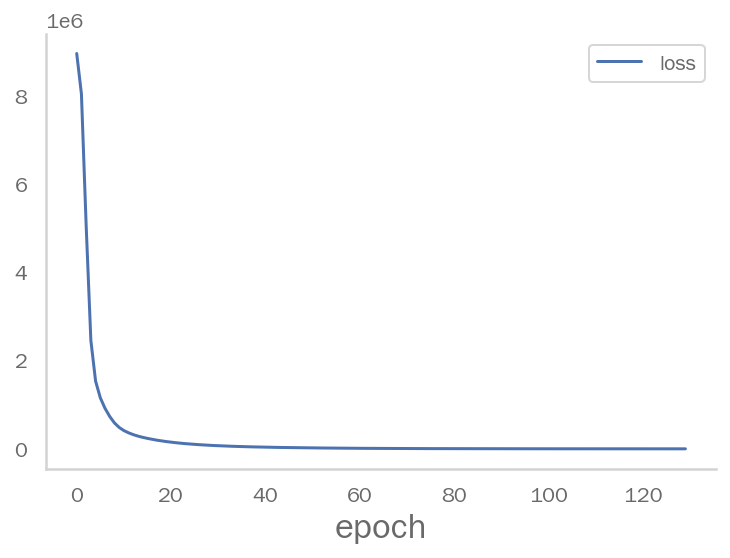

In [11]:
hist = pd.DataFrame(history.history)
hist["epoch"] = history.epoch
hist.plot(x="epoch", y="loss")


In [12]:
test_results["dnn_model"] = dnn_model.evaluate(test_features, test_label)

print(test_results)


27/27 [==============================] - 0s 3ms/step - loss: 5022.2842 - mean_absolute_error: 32.5008
{'linear_baseline': 7687890.5, 'dnn_model': [5022.2841796875, 32.50081253051758]}


In [13]:
test_predictions = {}
test_predictions["dnn_model"] = dnn_model.predict(test_features).flatten()


In [27]:
dtrain = xgb.DMatrix(train_features, label=train_label)
dtest = xgb.DMatrix(test_features, label=test_label)

param = {
    "max_depth": 50,
    "eta": 1,
    "objective": "reg:squarederror",
    "booster": "gbtree",
}
evallist = [(dtest, "eval"), (dtrain, "train")]

num_round = 2
xg = xgb.train(param, dtrain, num_round, evallist)


[0]	eval-rmse:94.23779	train-rmse:95.28025
[1]	eval-rmse:22.57579	train-rmse:14.05571


In [15]:
# test_results["xgb"] = xg.evaluate(test_features, test_label)

# print(test_results)

In [29]:
test_predictions["xgb"] = xg.predict(dtest)

print(test_predictions['xgb'])


[2755.9216 2741.9268 2777.0974 2777.0974 2777.0974 2678.2314 2678.2314
 2812.3845 2812.3845 2923.2092 2923.2092 2923.2092 3037.6626 3320.8435
 3320.8435 3386.8079 3432.7861 3187.8442 3304.14   3320.8435 3226.7761
 3375.7588 3407.108  3351.5054 3254.6873 3320.8435 3432.7861 3490.3672
 3407.108  3432.7861 3432.7861 3529.4937 3490.3672 3490.3672 3490.3672
 3490.3672 3432.7861 3490.3672 3490.3672 3529.4937 3529.4937 3529.4937
 3529.4937 3643.303  3825.9998 3917.1384 4009.4966 3917.1384 3917.1384
 3917.1384 4132.039  4132.039  3871.5159 3999.5364 4010.7358 4055.9133
 4055.9133 4132.039  4132.039  4280.4707 4055.9133 3704.6658 3871.5159
 3746.5974 3643.303  3643.303  3679.7734 3871.5159 3871.5159 3978.9282
 4055.9133 4055.9133 3917.1384 3825.9998 3825.9998 3529.4937 3490.3672
 3372.9333 3529.4937 3407.108  3490.3672 3320.8435 3187.8442 3432.7861
 3187.8442 3375.7588 3529.4937 3361.6775 3407.108  3386.8079 2923.2092
 2971.5664 2499.9985 2573.837  2765.8438 2865.5342 2780.6445 2717.3208
 2357.

In [17]:
# def conv_model(normalizer):
#     CONV_WIDTH = 3

#     model = tf.keras.models.Sequential(
#         [
#             normalizer,
#             # tf.keras.layers.Lambda(lambda x: x[:, -CONV_WIDTH:, :]),
#             # tf.keras.layers.Conv1D(
#             #     filters=64,
#             #     kernel_size=(CONV_WIDTH),
#             #     strides=1,
#             #     padding="causal",
#             #     # activation="relu",
#             # ),
#             tf.keras.layers.Bidirectional(
#                 tf.keras.layers.LSTM(128, return_sequences=False)
#             ),
#             # tf.keras.layers.Bidirectional(
#             #     tf.keras.layers.LSTM(64, return_sequences=True)),
#             tf.keras.layers.Dense(128),
#             tf.keras.layers.Dropout(0.2),
#             tf.keras.layers.Dense(1),
#         ]
#     )

#     model.compile(
#         loss="mse", optimizer="adam", metrics=[tf.metrics.MeanAbsoluteError()]
#     )

#     return model


In [18]:
# conv_model = conv_model(normalizer)

# conv_model.summary()


In [19]:
# %%time
# history = conv_model.fit(
#     train_features,
#     train_label,
#     validation_split=0.2,
#     epochs=2000, callbacks=[early_stopping])

In [20]:
# test_results["conv_model"] = dnn_model.evaluate(test_features, test_label)

# print(test_results)


In [21]:
# test_predictions["conv_model"] = dnn_model.predict(test_features).flatten()

# print(test_predictions)


In [22]:
def plot_result(labels, preds):
    plt.figure(figsize=(15, 10))
    plt.scatter(x=labels.index, y=labels, color="r", marker=".", label="real data")
    plt.scatter(x=labels.index, y=preds, color="b", marker="X", label="predictions")
    plt.xlabel("time")
    plt.ylabel("price")
    plt.title("Red is predictions, Blue is real data")
    plt.show()


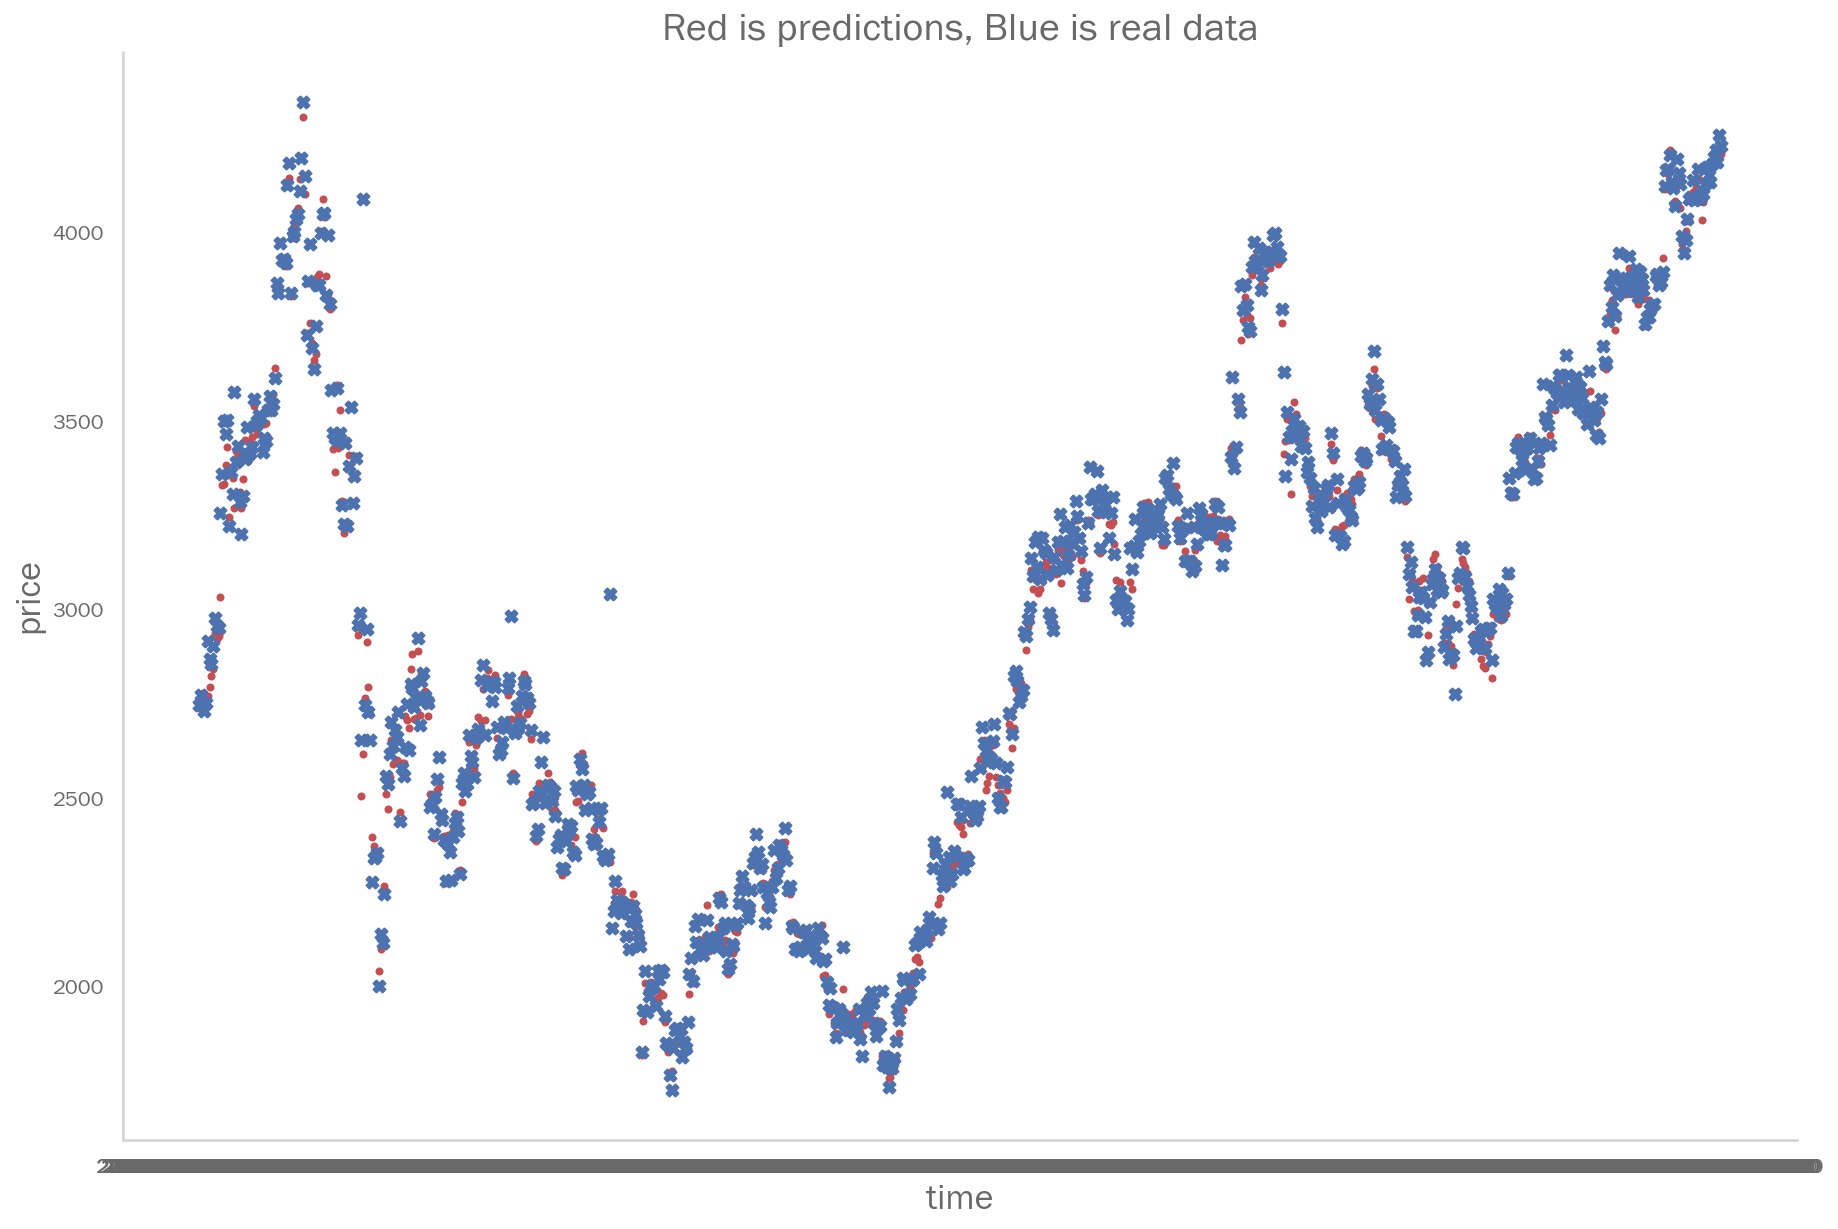

In [23]:
plot_result(test_label, test_predictions["dnn_model"])

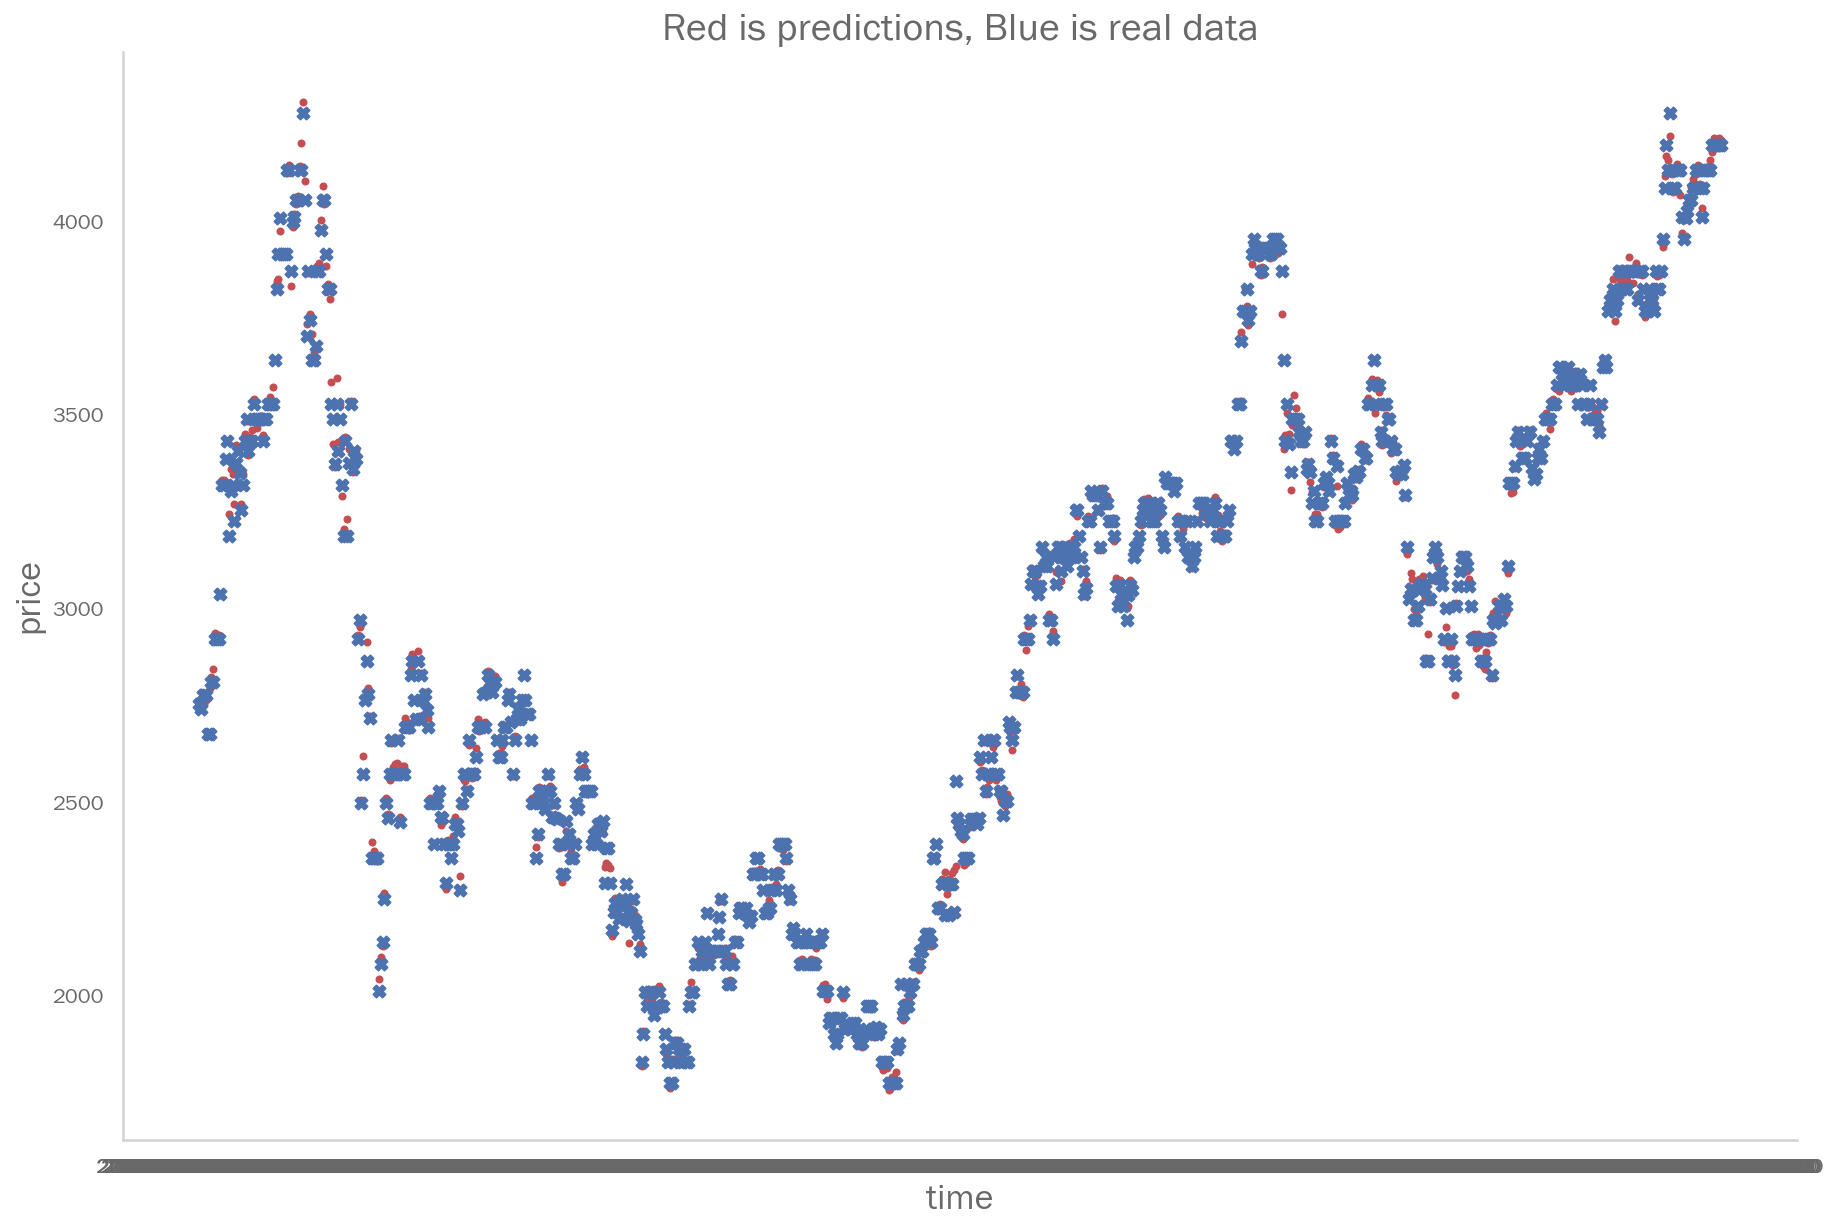

In [24]:
plot_result(test_label, test_predictions["xgb"])
